## 目的：
画像を主成分分析したデータと10*10の画像データを用い、それぞれ同じ分類手法（K近傍法及びランダムフォレスト）を用いることで、データの粒度によって分類精度にどの程度違いが出るかを確認する。 

仮説：　主成分分析したデータの方が10*10の画像データよりも粒度が低いため、分類精度も低い。

In [73]:
from sklearn.neighbors import KNeighborsClassifier#k近傍法
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold#今日は使わない
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

## データ作成（28*28）

In [74]:
# 各数字のmnist画像をデータ化（画像数＊784に）
path = '/Users/ShuntaroMiwa/00 python/muramatsu/mnist_subset/'
num = ["/0", "/1", "/2","/3", "/4", "/5","/6", "/7", "/8","/9"]
w = h = 28

nums=[]
for i in range(10):
    filelist = os.listdir(path + num[i])
    print(len(filelist))
    num2= np.zeros((len(filelist), w, h))
    n = 0            
    for file in filelist:
        img = Image.open(path +num[i]+"/"+ file)
        num2[n] = np.array(img)#ここのnがまだちょっと分からない（おそらく一次元目のn個目に２８*２８ができる）
        n += 1
    num2 = num2.reshape(num2.shape[0], num2.shape[1]*num2.shape[2]).astype('float32')/255
    nums.append(num2) 
  
nums = np.asarray(nums)

988
1123
993
1022
974
903
987
1044
975
991


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [106]:
zeros=nums[0]
ones=nums[1]
twos=nums[2]
threes=nums[3]
fours=nums[4]
fives=nums[5]
sixs=nums[6]
sevens=nums[7]
eights=nums[8]
nines=nums[9]
print(zeros.shape)
print(zeros)
print(type(zeros))
# plt.hist(zeros,stacked=True)

(988, 784)
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
<class 'numpy.ndarray'>


## データ作成（10*10）

In [102]:
# 学習画像の読み込みと特徴数削減

width = 10
height = 10

train_img = []
for i in range(10):
    filelist = os.listdir(path + num[i])
    #print(len(filelist))
    im = np.zeros((len(filelist), width, height))#(画像数*10*10のリスト)
    n = 0            
    for file in filelist:
        Img = Image.open(path +num[i]+"/"+ file)
        Img = Img.resize((width, height),Image.LANCZOS)
        im[n] = np.array(Img)
        #print(im[n])
        n += 1
    im = im.reshape(im.shape[0], im.shape[1]*im.shape[2]).astype('float32')/255
    train_img.append(im) 
    
train_img = np.asarray(train_img)

In [103]:
print(train_img)

[array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 0.99607843,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 0.99215686,
        1.        ],
       [1.        , 1.        , 1.        , ..., 0.99607843, 1.        ,
        1.        ]], dtype=float32)
 array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)
 array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.    

In [104]:
zeros_img=train_img[0]
ones_img=train_img[1]
twos_img=train_img[2]
threes_img=train_img[3]
fours_img=train_img[4]
fives_img=train_img[5]
sixs_img=train_img[6]
sevens_img=train_img[7]
eights_img=train_img[8]
nines_img=train_img[9]

# バリデーション（データ分け）

分散の差が小さいほど分類が難しいのではないかと考え、不偏分散を算出し、分散の差が小さい組み合わせを選択　→ ４と9

In [111]:
numlist=[zeros,ones,twos,threes,fours,fives,sixs,sevens,eights,nines]#２８*２８
train_imglist=[zeros_img, ones_img,twos_img, threes_img, fours_img, fives_img, sixs_img, sevens_img, eights_img, nines_img]#10*10リサイズ

x0=fours#分類１のデータ
x1=nines#分類２のデータ

In [108]:
#28*28画像
print("0画像の不偏分散＝",np.var(numlist[0],ddof=1))
print("1画像の不偏分散＝",np.var(numlist[1],ddof=1))
print("2画像の不偏分散＝",np.var(numlist[2],ddof=1))
print("3画像の不偏分散＝",np.var(numlist[3],ddof=1))
print("4画像の不偏分散＝",np.var(numlist[4],ddof=1))
print("5画像の不偏分散＝",np.var(numlist[5],ddof=1))
print("6画像の不偏分散＝",np.var(numlist[6],ddof=1))
print("7画像の不偏分散＝",np.var(numlist[7],ddof=1))
print("8画像の不偏分散＝",np.var(numlist[8],ddof=1))
print("9画像の不偏分散＝",np.var(numlist[9],ddof=1))

# for i in list:
#     print("不偏分散＝",np.var(list[i],ddof=1))
#     var = np.var(x0,ddof=1)

0画像の不偏分散＝ 0.12123674
1画像の不偏分散＝ 0.05928333
2画像の不偏分散＝ 0.105614185
3画像の不偏分散＝ 0.10175462
4画像の不偏分散＝ 0.08866746
5画像の不偏分散＝ 0.092394836
6画像の不偏分散＝ 0.09908951
7画像の不偏分散＝ 0.08352998
8画像の不偏分散＝ 0.10702628
9画像の不偏分散＝ 0.08822013


In [110]:
#10*10画像
print("0画像10*10の不偏分散＝",np.var(train_imglist[0],ddof=1))
print("1画像10*10の不偏分散＝",np.var(train_imglist[1],ddof=1))
print("2画像10*10の不偏分散＝",np.var(train_imglist[2],ddof=1))
print("3画像10*10の不偏分散＝",np.var(train_imglist[3],ddof=1))
print("4画像10*10の不偏分散＝",np.var(train_imglist[4],ddof=1))
print("5画像10*10の不偏分散＝",np.var(train_imglist[5],ddof=1))
print("6画像10*10の不偏分散＝",np.var(train_imglist[6],ddof=1))
print("7画像10*10の不偏分散＝",np.var(train_imglist[7],ddof=1))
print("8画像10*10の不偏分散＝",np.var(train_imglist[8],ddof=1))
print("9画像10*10の不偏分散＝",np.var(train_imglist[9],ddof=1))

# for i in list:
#     print("不偏分散＝",np.var(list[i],ddof=1))
#     var = np.var(x0,ddof=1)

0画像10*10の不偏分散＝ 0.089515455
1画像10*10の不偏分散＝ 0.044471115
2画像10*10の不偏分散＝ 0.076091096
3画像10*10の不偏分散＝ 0.07160666
4画像10*10の不偏分散＝ 0.063478574
5画像10*10の不偏分散＝ 0.0634769
6画像10*10の不偏分散＝ 0.071742035
7画像10*10の不偏分散＝ 0.060327463
8画像10*10の不偏分散＝ 0.07561374
9画像10*10の不偏分散＝ 0.061896235


In [114]:
T_size=180 #テスト及びバリデーションのサイズ

x0_labels = np.zeros((x0.shape[0], 1), dtype=int)
x0_trainV, x0_test, y0_trainV, y0_test = train_test_split(x0, x0_labels, test_size=T_size)
x0_train, x0_val, y0_train, y0_val = train_test_split(x0_trainV, y0_trainV, test_size=T_size)
print(x0_train.shape)
print(y0_train.shape)
print(x0_val.shape)
print(y0_val.shape)
print(x0_test.shape)
print(y0_test.shape)

x1_labels = np.ones((x1.shape[0], 1), dtype=int)
x1_trainV, x1_test, y1_trainV, y1_test = train_test_split(x1, x1_labels, test_size=T_size)
x1_train, x1_val, y1_train, y1_val = train_test_split(x1_trainV, y1_trainV, test_size=T_size)
print(x1_train.shape)
print(y1_train.shape)
print(x1_val.shape)
print(y1_val.shape)
print(x1_test.shape)
print(y1_test.shape)

(614, 784)
(614, 1)
(180, 784)
(180, 1)
(180, 784)
(180, 1)
(631, 784)
(631, 1)
(180, 784)
(180, 1)
(180, 784)
(180, 1)


In [115]:
x_train = np.concatenate((x0_train, x1_train), axis=0).astype('float32')
x_val = np.concatenate((x0_val, x1_val), axis=0).astype('float32')
x_test = np.concatenate((x0_test, x1_test), axis=0).astype('float32')
y_train = np.concatenate((y0_train, y1_train), axis=0).astype('float32')
y_val = np.concatenate((y0_val, y1_val), axis=0).astype('float32')
y_test = np.concatenate((y0_test, y1_test), axis=0).astype('float32')
print("number of x trains ", x_train.shape)
print("number of x validations ", x_val.shape)
print("number of x tests ", x_test.shape)
print("number of y trains ", y_train.shape)
print("number of y validations ", y_val.shape)
print("number of y tests ", y_test.shape)

number of x trains  (1245, 784)
number of x validations  (360, 784)
number of x tests  (360, 784)
number of y trains  (1245, 1)
number of y validations  (360, 1)
number of y tests  (360, 1)


(0.0, 700000.0)

<Figure size 432x288 with 0 Axes>

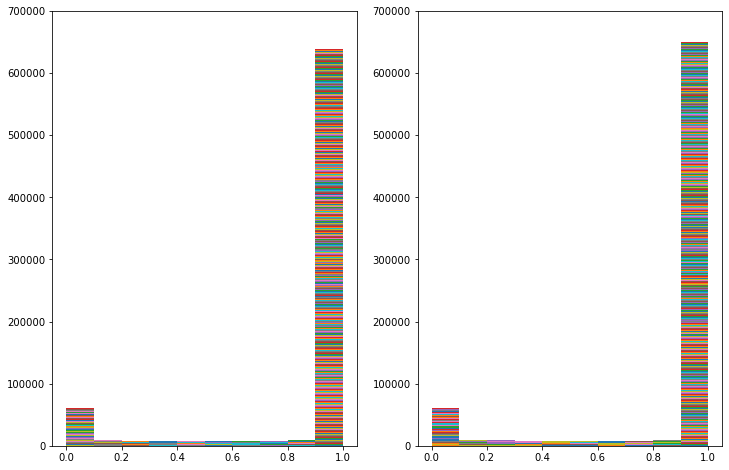

In [22]:
#分布をグラフに表示(積上げヒストグラム)

import matplotlib.pyplot as plt

#https://qiita.com/trami/items/bd54f22ee4449421f2bc
fig = plt.figure()
#add_subplot()でグラフを描画する領域を追加する．引数は行，列，場所
fig, axs = plt.subplots(1,2, figsize=(12, 8))

#t = np.linspace(0, 1, 255) 

axs[0].hist(x0,stacked=True)
axs[1].hist(x1,stacked=True)
axs[0].set_ylim(0,700000)
axs[1].set_ylim(0,700000)
#2次元ヒストグラム
#https://teratail.com/questions/144722

### 主成分分析による次元削減

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
(1245, 784)
(1245, 2)
不偏分散＝ 0.08871883
不偏標準偏差＝ 0.29785708
主成分の分散説明率（寄与率）
[0.14088793 0.09228885]
主成分の固有値
[5.758106  3.7718563]
固有ベクトル
[[ 6.1017232e-08 -2.1007587e-09 -1.3309893e-11 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 2.6328993e-07  9.7590478e-09  3.9619303e-09 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]


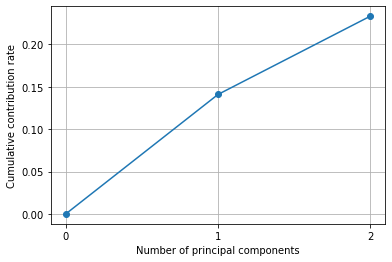

In [140]:
pca = PCA(n_components=2)#主成分分析, ２成分(784を2次元に)
train_pca = pca.fit_transform(x_train)#対角化して、X_stdを変換した結果を返す
val_pca = pca.fit_transform(x_val)
test_pca = pca.transform(x_test)#X_stdを変換した結果を返しますが、対角化は行わない
print(x_train)
print(x_train.shape)
print(train_pca.shape)#訓練データ
# print(test_pca.shape)
# print(train_pca)
# print(test_pca)

#不偏分散の算出（1407*784の全ての要素を対象）
print("不偏分散＝",np.var(x_train,ddof=1))
#不偏標準偏差の算出（1407*784の全ての要素を対象）
print("不偏標準偏差＝",np.std(x_train,ddof=1))

#https://qiita.com/maskot1977/items/082557fcda78c4cdb41f
print("主成分の分散説明率（寄与率）")
print(pca.explained_variance_ratio_)
print("主成分の固有値")
print(pca.explained_variance_)
print("固有ベクトル")
print(pca.components_)
      
import matplotlib.ticker as ticker
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.plot([0] + list( np.cumsum(pca.explained_variance_ratio_)), "-o")

#累積値をグラフに表示したいが分からないため保留
#for x, y in zip(pca.explained_variance_ratio_):
#    plt.text(x, y, y, ha='center', va='bottom')

plt.xlabel("Number of principal components")
plt.ylabel("Cumulative contribution rate")
plt.grid()
plt.show()

２成分の主成分分析の累積寄与率
(4と9の場合)　０．２２４

　→累積寄与率が高いほど、判別確率は高くなるのではないか？

t4: [[-0.72327    -0.5461825 ]
 [ 1.4425737  -0.7911461 ]
 [ 0.98506165 -0.43407062]
 ...
 [-1.0309162   4.709438  ]
 [-0.34806582  0.7715717 ]
 [-2.362124   -1.1606642 ]]
t5: [[-2.2095084  -1.9960148 ]
 [ 0.29934576 -0.8125272 ]
 [ 3.7187605  -1.2560068 ]
 ...
 [-3.4731565   1.5960673 ]
 [ 2.1678698  -0.6535806 ]
 [ 2.7122748   1.1806158 ]]


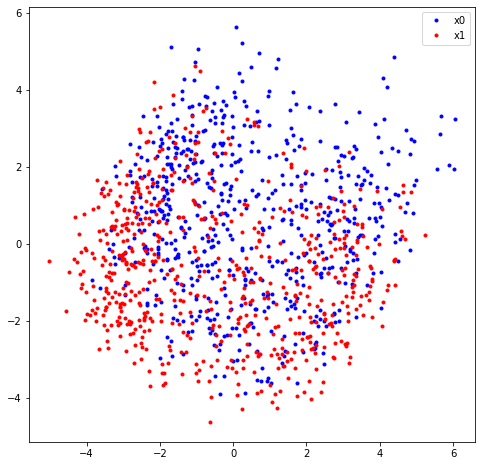

In [117]:
# 主成分得点（２成分）の可視化

fig, ax = plt.subplots(figsize=(8,8))
t4 = train_pca[np.where(y_train ==0)[0],:]
t5 = train_pca[np.where(y_train ==1)[0],:]
print("t4:",t4)
print("t5:",t5)
ax.plot(t4[:,0], t4[:,1], 'b.', label='x0')
ax.plot(t5[:,0], t5[:,1], 'r.', label='x1')
ax.legend(loc='upper right')

# グリッドサーチ（主成分分析とk近傍法）
主成分数＝２０、k=1の時に最も精度が高い（0.939）ことが示された。
（なお、２０成分の主成分分析の累積寄与率は0.70であり、上限の基準とされる.80まで達していない） 


In [167]:
#主成分分析とK近傍法についてグリッドサーチ

pca_comp = [1,3, 5, 10, 15, 20]
best_val_score = 0
best_param = {}

for i in pca_comp:
    for k in range(1, 31,2):
                pca = PCA(n_components=i)
                train_pca = pca.fit_transform(x_train)
                val_pca = pca.transform(x_val)
                #print(i,"成分時の分散説明率（寄与率）",pca.explained_variance_ratio_)
                knc = KNeighborsClassifier(n_neighbors=k)
                scores = cross_val_score(knn, val_pca, y_val, cv=5)
                mean_score = np.mean(scores)
                if mean_score > best_val_score:
                    best_val_score = mean_score
                    best_param = {'max_comp': i, 'max_k': k}

# out[best_val_score: 0.939]
# out[best_param:  {''max_comp': 20, 'max_k': 1}]
print('best_val_score: {:0.3f}'.format(best_val_score))
print('best_param: ', best_param)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

best_val_score: 0.939
best_param:  {'max_comp': 20, 'max_k': 1}


/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

## グリッドサーチの結果（主成分分析とランダムフォレスト）
主成分数＝２０、深さ=3、最低サンプル7の時に分割終了の時に最も精度が高い（0.900）ことが示された。→ｋ近傍法の方が精度が高い

In [161]:
#主成分分析とランダムフォレストについてグリッドサーチ
#https://qiita.com/Takayoshi_Makabe/items/d35eed0c3064b495a08b

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

pca_comp = [1,3, 5, 10, 15, 20]
depth = [2, 3, 4, 5, 6, 7]
leaf = [1, 3, 5, 7, 10]
best_val_score = 0
best_param = {}

for i in pca_comp:
    for ｊ in depth:
        for k in leaf:
            pca = PCA(n_components=i)
            train_pca = pca.fit_transform(x_train)
            val_pca = pca.transform(x_val)
            #print(i,"成分時の分散説明率（寄与率）",pca.explained_variance_ratio_)
            forest = RandomForestClassifier(n_estimators=10, max_depth=j, min_samples_leaf=k, random_state=0)
            scores = cross_val_score(forest, val_pca, y_val, cv=5)
            mean_score = np.mean(scores)
            if mean_score > best_val_score:
                best_val_score = mean_score
                best_param = {'max_comp': i, 'max_depth': j, "min_samples_leaf":k}

# out[best_val_score: 0.900]
# out[best_param:  {''max_comp': 20, 'max_depth': 4, 'min_samples_leaf': 7}]
print('best_val_score: {:0.3f}'.format(best_val_score))
print('best_param: ', best_param)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y wa

best_val_score: 0.900
best_param:  {'max_comp': 20, 'max_depth': 4, 'min_samples_leaf': 7}


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


以下、主成分分析とK近傍法の誤差やROC曲線を出力する。
auc=0.989
訓練・テストともに、Kの数を増やすと誤差が上昇することが確認された(K=1が最善とのグリッドサーチの結果と整合)。

/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

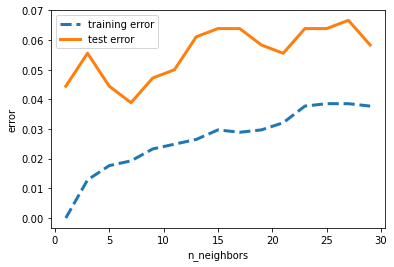

confusion matrix = 
[[164.  16.]
 [  5. 175.]]
Misclassified cases : [6, 9, 13, 14, 21, 23, 31, 35, 38, 94, 96, 97, 138, 139, 147, 162, 206, 211, 231, 235, 241]
auc = 0.989


Text(0, 0.5, 'True positive fraction')

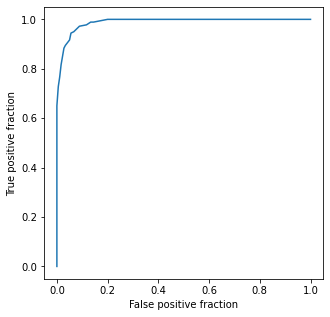

In [199]:
from sklearn.metrics import roc_curve#ROCは二分類のみ
from sklearn.metrics import roc_auc_score
import seaborn as sns

pca = PCA(n_components=20)
train_pca = pca.fit_transform(x_train)
test_pca = pca.transform(x_test)

list_nn = []
list_tr_score = []
list_te_score = []
for k in range(1, 31,2): # K = 1~30
    knc = KNeighborsClassifier(n_neighbors=k)
    knc.fit(train_pca, y_train)
    #Y_pred = knc.predict(test_pca)#予測
    tr_score = knc.score(train_pca, y_train)
    te_score = knc.score(test_pca, y_test)#評価
    #print("[%d] score: {:.2f}".format(score) % k)
    list_nn.append(k)
    list_tr_score.append(1-tr_score)
    list_te_score.append(1-te_score)

plt.xlabel('n_neighbors')
plt.ylabel('error')
plt.plot(list_nn, list_tr_score,label='training error',linestyle='dashed',lw=3)
plt.plot(list_nn, list_te_score,label='test error',    linestyle='solid', lw=3)
plt.legend()
plt.show()

# 混同行列と分類失敗ケース(手計算)
cmat = np.zeros((2,2))
n = 0
failed = []
for y_true, y_pred in zip(y_test, knc.predict(test_pca)):
    cmat[int(y_true)][int(y_pred)] += 1
    if (y_true != y_pred):
        failed.append(n)
    n += 1
print("confusion matrix = ")
print(cmat)
print("Misclassified cases :", failed)

# 混同行列 test data
cmat = np.zeros((2,2))
for y_true, y_pred in zip(y_test, knc.predict(test_pca)):
    cmat[int(y_true)][int(y_pred)] += 1

# 分類結果と確率
y_pred = knc.predict(test_pca)
prob = knc.predict_proba(test_pca)

fpf, tpf, thresholds = roc_curve(y_test, prob[:,1])#testデータで正解
auc = roc_auc_score(y_test, prob[:,1])#testデータで予測
"\n"
print("auc = {:.3f}".format(auc))

fig2,ax2 = plt.subplots(figsize=(5,5))
ax2.plot(fpf,tpf)
ax2.set_xlabel('False positive fraction')
ax2.set_ylabel('True positive fraction')

以下、主成分分析とランダムフォレストの誤差やROC曲線を出力する。
auc=0.954（K近傍法より低い）
訓練・テストともに、訓練回数を増やすと誤差が減少することが確認された(100本まで過学習は確認されなかった)。

<ipython-input-200-826385ec94cf>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(train_pca, y_train)
<ipython-input-200-826385ec94cf>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(train_pca, y_train)
<ipython-input-200-826385ec94cf>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(train_pca, y_train)
<ipython-input-200-826385ec94cf>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(train_pca, y_train)
<ipython-input-200-826385ec94cf>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

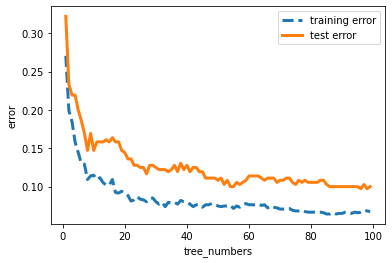

confusion matrix = 
[[153.  27.]
 [  9. 171.]]
Misclassified cases : [3, 6, 7, 13, 18, 21, 22, 23, 27, 31, 35, 56, 81, 89, 94, 97, 98, 101, 105, 118, 138, 139, 141, 142, 147, 162, 176, 206, 211, 248, 251, 257, 275, 328, 329, 348]
auc = 0.954


Text(0, 0.5, 'True positive fraction')

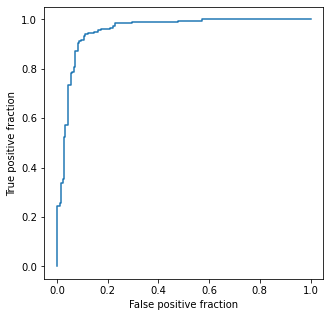

In [200]:
from sklearn import tree, ensemble

rf = ensemble.RandomForestClassifier(max_depth=3, min_samples_leaf=7,random_state=0)

list_nn = []
list_tr_score = []
list_te_score = []
for k in range(1,100): 
    rf.set_params(n_estimators=k)
    rf.fit(train_pca, y_train)
    #Y_pred = knc.predict(test_pca)#予測
    tr_score = rf.score(train_pca, y_train)
    te_score = rf.score(test_pca, y_test)#評価
    #print("[%d] score: {:.2f}".format(score) % k)
    list_nn.append(k)
    list_tr_score.append(1-tr_score)
    list_te_score.append(1-te_score)

plt.xlabel('tree_numbers')
plt.ylabel('error')
plt.plot(list_nn, list_tr_score,label='training error',linestyle='dashed',lw=3)
plt.plot(list_nn, list_te_score,label='test error',    linestyle='solid', lw=3)
plt.legend()
plt.show()

# 混同行列と分類失敗ケース(手計算)
cmat = np.zeros((2,2))
n = 0
failed = []
for y_true, y_pred in zip(y_test, rf.predict(test_pca)):
    cmat[int(y_true)][int(y_pred)] += 1
    if (y_true != y_pred):
        failed.append(n)
    n += 1
print("confusion matrix = ")
print(cmat)
print("Misclassified cases :", failed)

# 混同行列 test data
cmat = np.zeros((2,2))
for y_true, y_pred in zip(y_test, rf.predict(test_pca)):
    cmat[int(y_true)][int(y_pred)] += 1

# 分類結果と確率
y_pred = rf.predict(test_pca)
prob = rf.predict_proba(test_pca)

fpf, tpf, thresholds = roc_curve(y_test, prob[:,1])#valデータで正解
auc = roc_auc_score(y_test, prob[:,1])#valデータで予測
"\n"
print("auc = {:.3f}".format(auc))

fig2,ax2 = plt.subplots(figsize=(5,5))
ax2.plot(fpf,tpf)
ax2.set_xlabel('False positive fraction')
ax2.set_ylabel('True positive fraction')

## データを10*10に変更し（主成分分析なし）、同様の分析を行う。 

In [201]:
T_size=180 #テスト及びバリデーションのサイズ

x0=fours_img#分類１(10*10)のデータ
x1=nines_img#分類２(10*10)のデータ

x0_labels = np.zeros((x0.shape[0], 1), dtype=int)
x0_trainV, x0_test, y0_trainV, y0_test = train_test_split(x0, x0_labels, test_size=T_size)
x0_train, x0_val, y0_train, y0_val = train_test_split(x0_trainV, y0_trainV, test_size=T_size)

x1_labels = np.ones((x1.shape[0], 1), dtype=int)
x1_trainV, x1_test, y1_trainV, y1_test = train_test_split(x1, x1_labels, test_size=T_size)
x1_train, x1_val, y1_train, y1_val = train_test_split(x1_trainV, y1_trainV, test_size=T_size)

x_train = np.concatenate((x0_train, x1_train), axis=0).astype('float32')
x_val = np.concatenate((x0_val, x1_val), axis=0).astype('float32')
x_test = np.concatenate((x0_test, x1_test), axis=0).astype('float32')
y_train = np.concatenate((y0_train, y1_train), axis=0).astype('float32')
y_val = np.concatenate((y0_val, y1_val), axis=0).astype('float32')
y_test = np.concatenate((y0_test, y1_test), axis=0).astype('float32')

## K近傍法

グリッドサーチはK=3を示した。

In [203]:
best_val_score = 0
best_param = {}

for k in range(1, 31,2):
                knc = KNeighborsClassifier(n_neighbors=k)
                scores = cross_val_score(knc, x_val, y_val, cv=5)
                mean_score = np.mean(scores)
                if mean_score > best_val_score:
                    best_val_score = mean_score
                    best_param = {'max_k': k}

# out[best_val_score: 0.936]
# out[best_param:  {'max_k': 3}]
print('best_val_score: {:0.3f}'.format(best_val_score))
print('best_param: ', best_param)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

best_val_score: 0.936
best_param:  {'max_k': 3}


/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

K近傍法の誤差やROC曲線を出力。
auc=0.994で主成分分析時(.989)よりやや上昇。
訓練・テストともに、K=1から3の時に汎化誤差と訓練誤差は異なる動きをしているが、全体としてはKの数を増やすと誤差が上昇することが確認された(K=3が最善とのグリッドサーチの結果と整合)。

/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

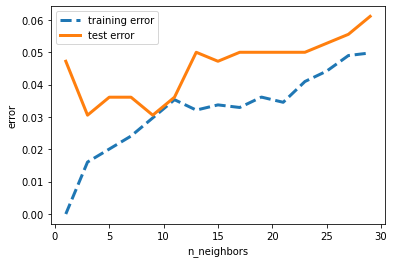

confusion matrix = 
[[161.  19.]
 [  3. 177.]]
Misclassified cases : [3, 4, 18, 19, 21, 24, 41, 49, 52, 65, 82, 93, 97, 102, 105, 117, 125, 163, 173, 221, 279, 302]
auc = 0.994


Text(0, 0.5, 'True positive fraction')

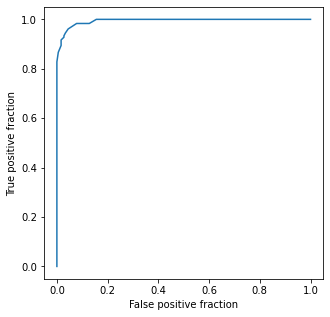

In [204]:
list_nn = []
list_tr_score = []
list_te_score = []
for k in range(1, 31,2): # K = 1~30
    knc = KNeighborsClassifier(n_neighbors=k)
    knc.fit(x_train, y_train)
    tr_score = knc.score(x_train, y_train)
    te_score = knc.score(x_test, y_test)#評価
    #print("[%d] score: {:.2f}".format(score) % k)
    list_nn.append(k)
    list_tr_score.append(1-tr_score)
    list_te_score.append(1-te_score)

plt.xlabel('n_neighbors')
plt.ylabel('error')
plt.plot(list_nn, list_tr_score,label='training error',linestyle='dashed',lw=3)
plt.plot(list_nn, list_te_score,label='test error',    linestyle='solid', lw=3)
plt.legend()
plt.show()

# 混同行列と分類失敗ケース(手計算)
cmat = np.zeros((2,2))
n = 0
failed = []
for y_true, y_pred in zip(y_test, knc.predict(x_test)):
    cmat[int(y_true)][int(y_pred)] += 1
    if (y_true != y_pred):
        failed.append(n)
    n += 1
print("confusion matrix = ")
print(cmat)
print("Misclassified cases :", failed)

# 混同行列 test data
cmat = np.zeros((2,2))
for y_true, y_pred in zip(y_test, knc.predict(x_test)):
    cmat[int(y_true)][int(y_pred)] += 1

# 分類結果と確率
y_pred = knc.predict(x_test)
prob = knc.predict_proba(x_test)

fpf, tpf, thresholds = roc_curve(y_test, prob[:,1])#testデータで正解
auc = roc_auc_score(y_test, prob[:,1])#testデータで予測
"\n"
print("auc = {:.3f}".format(auc))

fig2,ax2 = plt.subplots(figsize=(5,5))
ax2.plot(fpf,tpf)
ax2.set_xlabel('False positive fraction')
ax2.set_ylabel('True positive fraction')

## ランダムフォレスト

グリッドサーチは深さ=7, 最低サンプル5の時に分割終了の時を示した。

In [207]:
best_val_score = 0
best_param = {}

for ｊ in depth:
        for k in leaf:
            #print(i,"成分時の分散説明率（寄与率）",pca.explained_variance_ratio_)
            forest = RandomForestClassifier(n_estimators=10, max_depth=j, min_samples_leaf=k, random_state=0)
            scores = cross_val_score(forest, x_val, y_val, cv=5)
            mean_score = np.mean(scores)
            if mean_score > best_val_score:
                best_val_score = mean_score
                best_param = {'max_depth': j, "min_samples_leaf":k}

# out[best_val_score: 0.900]
# out[best_param:  {'max_depth': 4, 'min_samples_leaf': 7}]
print('best_val_score: {:0.3f}'.format(best_val_score))
print('best_param: ', best_param)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y wa

best_val_score: 0.931
best_param:  {'max_depth': 7, 'min_samples_leaf': 5}


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y wa

ランダムフォレストの誤差やROC曲線を出力。 auc=0.995で主成分分析時(.954)より上昇、K近傍法を上回った。 汎化誤差と訓練誤差は木の数50本目程度で底をうち、過学習は確認されなかった。

<ipython-input-210-acb8e87c037e>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)
<ipython-input-210-acb8e87c037e>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)
<ipython-input-210-acb8e87c037e>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)
<ipython-input-210-acb8e87c037e>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)
<ipython-input-210-acb8e87c037e>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

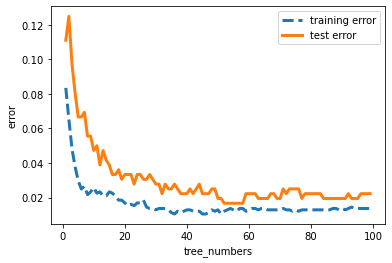

confusion matrix = 
[[176.   4.]
 [  4. 176.]]
Misclassified cases : [4, 18, 21, 65, 181, 262, 279, 300]
auc = 0.995


Text(0, 0.5, 'True positive fraction')

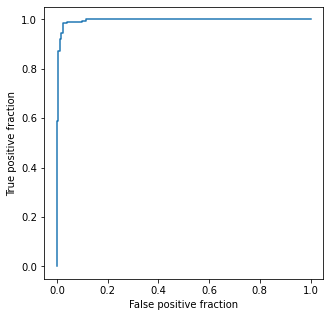

In [210]:
rf = ensemble.RandomForestClassifier(max_depth=7, min_samples_leaf=5,random_state=0)

list_nn = []
list_tr_score = []
list_te_score = []
for k in range(1,100): 
    rf.set_params(n_estimators=k)
    rf.fit(x_train, y_train)
    #Y_pred = knc.predict(test_pca)#予測
    tr_score = rf.score(x_train, y_train)
    te_score = rf.score(x_test, y_test)#評価
    #print("[%d] score: {:.2f}".format(score) % k)
    list_nn.append(k)
    list_tr_score.append(1-tr_score)
    list_te_score.append(1-te_score)

plt.xlabel('tree_numbers')
plt.ylabel('error')
plt.plot(list_nn, list_tr_score,label='training error',linestyle='dashed',lw=3)
plt.plot(list_nn, list_te_score,label='test error',    linestyle='solid', lw=3)
plt.legend()
plt.show()

# 混同行列と分類失敗ケース(手計算)
cmat = np.zeros((2,2))
n = 0
failed = []
for y_true, y_pred in zip(y_test, rf.predict(x_test)):
    cmat[int(y_true)][int(y_pred)] += 1
    if (y_true != y_pred):
        failed.append(n)
    n += 1
print("confusion matrix = ")
print(cmat)
print("Misclassified cases :", failed)

# 混同行列 test data
cmat = np.zeros((2,2))
for y_true, y_pred in zip(y_test, rf.predict(x_test)):
    cmat[int(y_true)][int(y_pred)] += 1

# 分類結果と確率
y_pred = rf.predict(x_test)
prob = rf.predict_proba(x_test)

fpf, tpf, thresholds = roc_curve(y_test, prob[:,1])#valデータで正解
auc = roc_auc_score(y_test, prob[:,1])#valデータで予測
"\n"
print("auc = {:.3f}".format(auc))

fig2,ax2 = plt.subplots(figsize=(5,5))
ax2.plot(fpf,tpf)
ax2.set_xlabel('False positive fraction')
ax2.set_ylabel('True positive fraction')

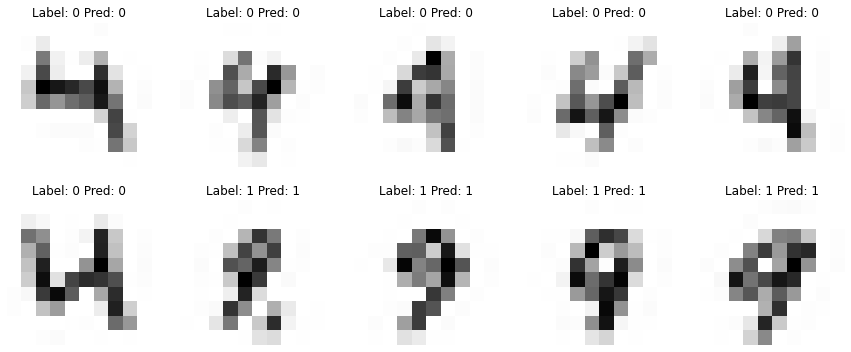

In [212]:
fig,ax = plt.subplots(2,5, figsize=(15,6))

n = 0
for i in range(0,2):
    for j in range(0,5):
        ax[i,j].imshow(x_test[n].reshape(height,width),cmap='gray')
        ax[i,j].set_title(f"Label: {int(y_test[n])} Pred: {int(y_pred[n])}")
        ax[i,j].axis('off')
        n += 30

## まとめ 

・粒度の違いが分類精度に反映されるとの仮説が一部支持された一方で、分類器によって精度の変化に違いが見られた。すなわち、今回扱ったデータでは、K近傍法は粒度の違いに関わらず高い精度を示し、精度の違いはほとんど見られなかったが、ランダムフォレストでは粒度が向上すると精度が上昇し、10*10のデータではK近傍法をごくわずかではあるが上回った。

・すなわち、分類器によって粒度の高さに対応可能かどうかは異なっており、ランダムフォレストでは対応でき、K近傍法では対応できない可能性がある。そのことを確認するには、より粒度の高いデータで検証することが求められる。

（その他学んだこと）バリデーションデータの作り方、グリッドサーチの実装など